In [460]:
#Import libraries
import pandas as pd 
import numpy as np 
import nltk
import ssl
from nltk import ne_chunk
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tree import Tree
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import string

ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/maxwelllondon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/maxwelllondon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/maxwelllondon/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/maxwelllondon/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/maxwelllondon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [461]:
#Read in data
df = pd.read_csv("./chatgpt.csv.bz2").sample(50000)

In [462]:
df.head()

,date,id,content,username,like_count,retweet_count
310613,2023-03-28 08:05:34+00:00,1640626166481448961,Google's #BardAI is weaker than #ChatGPT with...,aguadoorea,1.0,0.0
334904,2023-02-16 13:15:46+00:00,1626208716512174081,I have had the opportunity to interact with ch...,EliMasterpiece,2.0,0.0
241162,2023-02-19 06:28:20+00:00,1627193347772387328,Chat GPT also suffered from not being able to ...,InvMindsetTrade,0.0,0.0
201682,2023-03-16 18:27:15+00:00,1636433967057387520,"@Tired13492129 She must be a ""MAGA"" person so ...",BRICbreaker,1.0,0.0
263990,2023-03-21 14:00:24+00:00,1638178750369271810,Today is UNESCO World #PoetryDay. ChatGPT wrot...,PlasmaphysikIPP,3.0,0.0


In [463]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

df = df.dropna()

Missing values:
date             0
id               1
content          1
username         2
like_count       6
retweet_count    6
dtype: int64


In [464]:
print("Data types:")
print(df.dtypes)

Data types:
date              object
id                object
content           object
username          object
like_count       float64
retweet_count    float64
dtype: object


In [465]:
print("Summary statistics:")
print(df.describe())

Summary statistics:
         like_count  retweet_count
count  49994.000000   49994.000000
mean       5.726487       1.357883
std       91.044784      32.097621
min        0.000000       0.000000
25%        0.000000       0.000000
50%        1.000000       0.000000
75%        2.000000       0.000000
max     9114.000000    5429.000000


In [466]:
# Download stopwords if not already downloaded
nltk.download('stopwords')

# Get the list of stopwords and punctuation
stopwords_list = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)

# Define a function to perform tokenization with checks for special characters and stop words
def tokenize_text(text):
    tokens = nltk.word_tokenize(str(text))
    return tokens

# Tokenize the text data in the "content" column
df['content_tokenized'] = df['content'].apply(tokenize_text)

In [467]:
def perform_ner(tokenized_text):
    
    tagged_text = nltk.pos_tag(tokenized_text)  # Perform part-of-speech tagging, label nouns, verbs, adjectives, etc. 
    
    ner_result = ne_chunk(tagged_text)  # Perform named entity recognition, perform named entity recognition
    return ner_result

# Apply NER to the 'content_tokenized' column
df['ner_result'] = df['content_tokenized'].apply(perform_ner)

In [468]:


# Flatten the named entity results and extract named entities
flattened_entities = []

# Extract named entities
for sublist in df['ner_result']:
    for ent in sublist:
        if isinstance(ent, Tree):
            flattened_entities.append(' '.join([token[0] for token in ent.leaves()]))

# Count the frequency of named entities
entity_counts = Counter(flattened_entities)

# Set the number of top named entities to display
top_n = 10

# Get the top N named entities
top_entities = entity_counts.most_common(top_n)

# Display the top N named entities
for entity, count in top_entities:
    print(entity, count)

# Extract entities and counts for plotting
entities = [entity for entity, count in top_entities]
counts = [count for entity, count in top_entities]

# Plot the bar chart
plt.bar(range(len(entities)), counts, align='center')
plt.xticks(range(len(entities)), entities, rotation=45)
plt.xlabel('Named Entities')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Named Entities')
plt.tight_layout()
plt.show()

In [476]:
# Specify the percentage threshold for a given tweet, this percentage cuts off tweets that have 
#under X% of tokens/words that are present in the vader lexicon and correctly processed

threshold = 0.35  # Specify the desired threshold (e.g., 20%)

# Index of specific tweet to analyze, this is mainly used for debugging but it is intersting to see how the tokenization works. 

tweet_index = 50



import nltk
from nltk.corpus import stopwords
import string
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import re

# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Get the list of stopwords and punctuation
stopwords_list = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)

# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Define a function to perform tokenization with checks for special characters, stop words, and VADER lexicon presence
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)  # Tokenize the text

    #Remove tokens starting with a special character
    tokens = [token for token in tokens if not re.match(r'^[^a-zA-Z0-9]', token)]

    # Remove URLs and links
    tokens = [token for token in tokens if not re.match(r'^https?://[^\s]+', token)]

    # Remove trailing special characters
    tokens = [token.strip(string.punctuation) for token in tokens]

    # Convert tokens to lowercase
    tokens = [token.lower() for token in tokens]

    tokens = [token for token in tokens if len(token) > 1]

    stop_words = set(stopwords.words('english'))
    
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

def filter_tokens(tokens):
    filtered_tokens = [token for token in tokens if token not in stopwords_list and token in sid.lexicon]
    filtered_tokens = [token for token in filtered_tokens if token not in punctuation_set]
    return filtered_tokens

# Define a function to print words and their sentiment scores
def print_word_sentiment(tokens):
    for token in tokens:
        scores = sid.polarity_scores(token)
        print(f"Word: {token}\tSentiment Scores: {scores}")

# Define a function to calculate the average sentiment score for a tweet
def calculate_average_score(tokens):
    scores = [sid.polarity_scores(token)['compound'] for token in tokens]
    return sum(scores) / len(scores) if scores else 0.0

# Define a function to check if the given percentage of words are successfully tokenized and calculate the tokenization percentage
def check_tokenization_threshold(tokens, threshold):
    num_tokens = len(tokens)
    if num_tokens == 0:
        return False, 0.0
    filtered_tokens = filter_tokens(tokens)
    num_successful_tokens = len(filtered_tokens)
    tokenization_percentage = num_successful_tokens / num_tokens
    return tokenization_percentage >= threshold, tokenization_percentage

df['content_tokenized'] = df['content'].apply(tokenize_text)
df['tokenization_percentage'] = df['content_tokenized'].apply(lambda tokens: check_tokenization_threshold(tokens, threshold)[1])

# Filter out texts that don't meet the tokenization threshold
df = df[df['tokenization_percentage'] >= threshold]

# Example usage to select and analyze a specific tweet by index
selected_tweet = df['content'].iloc[tweet_index]
tokenized_tweet = df['content_tokenized'].iloc[tweet_index]

if tokenized_tweet:
    print(f"Selected Tweet: {selected_tweet}")
    print("\nTokenized Content:")
    print(tokenized_tweet)

    print("\nIndividual Word Sentiment Scores:")
    print_word_sentiment(tokenized_tweet)

    average_score = calculate_average_score(tokenized_tweet)
    print(f"\nAverage Score: {average_score}")
else:
    print("Text does not meet the tokenization threshold and cannot be analyzed.")

# Print the updated DataFrame with the tokenization percentage column
print(df)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxwelllondon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/maxwelllondon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Selected Tweet: Why #AI #creativity is different from #human  creativity ?

#creative #people, #designers , don't worry, 
#chatgpt  is very polite and admit you're different. 

Not better, just different... 🤣 https://t.co/kZ5364uCWA

Tokenized Content:
['ai', 'creativity', 'different', 'human', 'creativity', 'creative', 'people', 'designers', "n't", 'worry', 'chatgpt', 'polite', 'admit', 'different', 'better', 'different', 'https']

Individual Word Sentiment Scores:
Word: ai	Sentiment Scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Word: creativity	Sentiment Scores: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3818}
Word: different	Sentiment Scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Word: human	Sentiment Scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Word: creativity	Sentiment Scores: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3818}
Word: creative	Sentiment Scores: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4404}
Wo

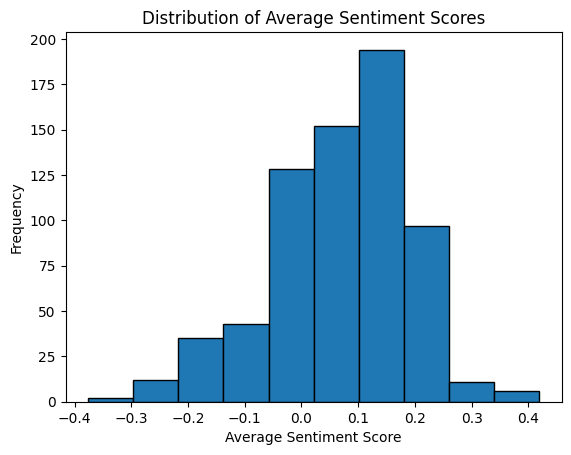

680

In [477]:
# Calculate the average sentiment score for each tweet
df['average_sentiment'] = df['content_tokenized'].apply(calculate_average_score)

# Create a distribution plot of the average sentiment scores
plt.hist(df['average_sentiment'], bins=10, edgecolor='black')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Average Sentiment Scores')
plt.show()